# Get data

In [1]:
# !apt-get update
# !apt-get install wget

In [2]:
# !wget 'YOUR_URL_HERE' -O 'flowers.zip'

In [ ]:
path = Path('../data/flowers/').resolve()

In [7]:
# from zipfile import ZipFile

# with ZipFile('flowers.zip', 'r') as zip_ref:
#     zip_ref.extractall(path)

# Other prerequisites

Note: you need to go into `tfrecord/__init__.py` and change:
- the first two instances of `tf.python_io` to `tf.io`
- the final instance of `tf.python_io` to `tf.compat.v1.io`

In [3]:
# !git clone https://github.com/pgmmpk/tfrecord.git

In [4]:
# !conda install tensorflow -y

In [ ]:
# !pip install gpustat

# Imports

In [5]:
import tensorflow as tf
from tfrecord.tfrecord import *

from fastai2.vision.all import *

# Loading data

In [8]:
def unpack_sample(feats):
    return {
        'class' : unpack_int64_list(feats['class']),
        'image' : unpack_bytes_list(feats['image'])
    }

In [9]:
train_fnames = get_files(path/'train', extensions='.tfrec')
test_fnames = get_files(path/'val', extensions='.tfrec')

In [10]:
data = []
for name in train_fnames+test_fnames:
    r = Reader(str(name), unpack_sample)
    for sample in r:
        data.append([sample['image'][0], sample['class'][0]])

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [11]:
len(data)

16465

# DataLoaders

In [12]:
get_x = lambda o: PILImage.create(io.BytesIO(o[0]))
get_y = lambda o: o[1]

In [13]:
def get_items(noop): return data

In [14]:
splitter = IndexSplitter(range(12753, len(data)))

## Transforms and augmentation

In [17]:
item_tfms = [RandomResizedCrop(224, min_scale=0.6), FlipItem(0.5)]
batch_tfms = [*aug_transforms()]

In [18]:
block = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_items,
    get_x=get_x,
    get_y=get_y,
    splitter=splitter,
    item_tfms=item_tfms,
    batch_tfms=batch_tfms
)

In [24]:
dls = block.dataloaders('', bs=64)

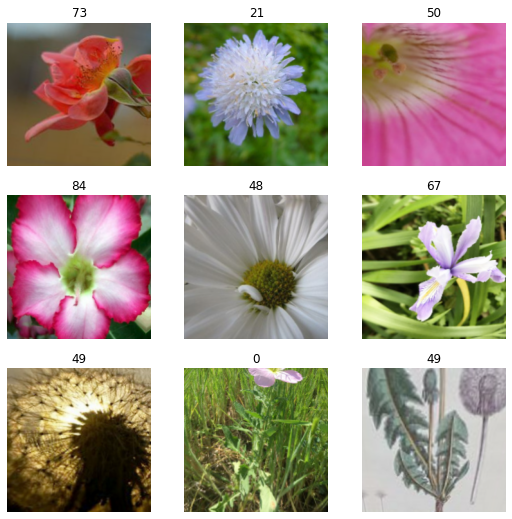

In [20]:
dls.show_batch()

# Learner

(0.010000000149011612, 0.004365158267319202)

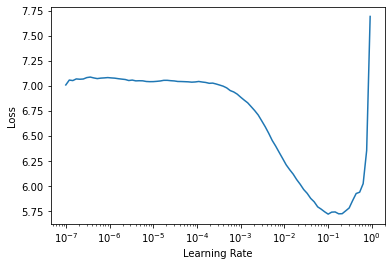

In [25]:
net = xresnet50(pretrained=False, sa=True, act_cls=Mish)
learn = Learner(dls, net, opt_func=ranger, metrics=accuracy)

learn.lr_find()

In [ ]:
net = xresnet50(pretrained=False, sa=True, act_cls=Mish)
learn = Learner(dls, net, opt_func=ranger, metrics=accuracy)
learn.fit_flat_cos(5, 8e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.777772,2.564047,0.333782,02:30
